In [23]:
import sys
import numpy as np
import scipy.sparse
%matplotlib notebook
import shapely
import lofarantpos.db
from scipy.sparse import csgraph
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import cdist
import os
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from shapely.geometry import Point, LineString, Polygon
import descartes
import csv
import math
import logging
db = lofarantpos.db.LofarAntennaDatabase()
station_name = "IE613LBA"
antpos = db.antenna_pqr(station_name)[:, :2]

In [13]:
myinstallprefix = r"C:\Users\thoma\Anaconda3\lib\site-packages"

<IPython.core.display.Javascript object>


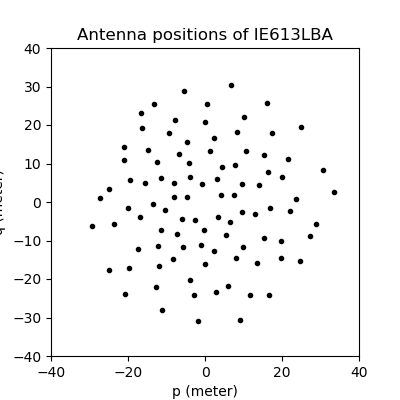

In [281]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.plot(antpos[:,0], antpos[:,1], 'k.')
ax.set_xlabel("p (meter)")
ax.set_ylabel("q (meter)")
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_title(f"Antenna positions of {station_name}")
ax.set_aspect(1)

Compute the distance between all antennas. For now, we use the regular (Euclidean) distance.

In [55]:
distmatrix = cdist(antpos, antpos)

We regard the distance matrix as a graph, with edge weights the distance. The minimum spanning tree of this graph eliminates duplicate edges.

In [56]:
msp = csgraph.minimum_spanning_tree(distmatrix).toarray()

<IPython.core.display.Javascript object>


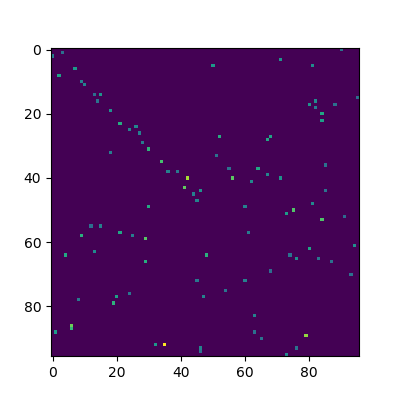

In [57]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.imshow(msp);

<IPython.core.display.Javascript object>


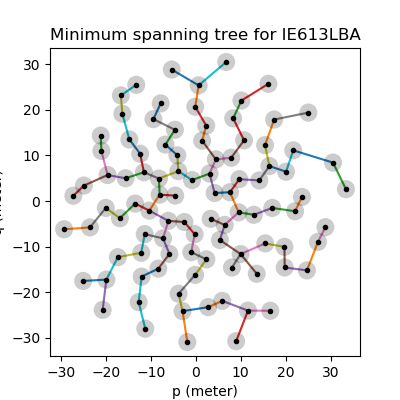

In [58]:
fig, ax = plt.subplots(figsize = (4,4))
ax.set_xlabel("p (meter)")
ax.set_ylabel("q (meter)")
ax.set_title(f"Minimum spanning tree for {station_name}")
ax.plot(antpos[:,0], antpos[:,1], 'k.', zorder=2)
for ant in antpos:
    ax.add_artist(Circle(ant, radius=2, facecolor='black', alpha=0.2))
for ant1 in range(len(antpos)):
    for ant2 in range(len(antpos)):
        if msp[ant1, ant2] > 0:
            ax.plot([antpos[ant1, 0], antpos[ant2, 0]], [antpos[ant1, 1], antpos[ant2, 1]], zorder=1)

This is not a good solution: all cables go to the middle, where there are a lot of stations. We will be digging through antennas. Let's try to alter the weights to avoid antennas.

We now want to make a distance function which gets a penalty for going through a lot of circles. Line and circle intersection can be done with shapely.

(I'm learning this from https://stackoverflow.com/questions/30844482/what-is-most-efficient-way-to-find-the-intersection-of-a-line-and-a-circle-in-py , http://toblerity.org/shapely/manual.html , https://deparkes.co.uk/2015/03/11/how-to-plot-polygons-in-python/)

<IPython.core.display.Javascript object>


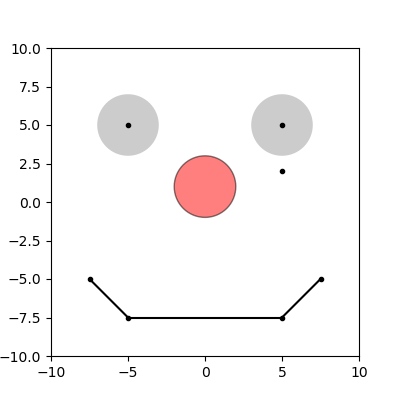

In [42]:
point1 = Point([5,5])
buf1 = point1.buffer(2)
point2 = Point([-5,5])
buf2 = point2.buffer(2)
point3 = Point([0,1])
buf3 = point3.buffer(2)
point4 = Point([-7.5,-5])
buf4 = point4.buffer(2)
point5 = Point ([-5,-7.5])
buf5 = point5.buffer(2)
point6 = Point([5,-7.5])
buf6 = point6.buffer(2)
point7 = Point([7.5,-5])
buf7 = point7.buffer(2)
fig, ax = plt.subplots(figsize = (4, 4))
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_aspect(1)

ax.plot(point1.xy[0], point1.xy[1], 'k.')
ax.plot(point2.xy[0], point2.xy[1], 'k.')
ax.plot(point4.xy[0], point4.xy[1], 'k.')
ax.plot(point5.xy[0], point5.xy[1], 'k.')
ax.plot(point6.xy[0], point6.xy[1], 'k.')
ax.plot(point7.xy[0], point7.xy[1], 'k.')
ax.plot(5, 2, 'k.')

ax.add_patch(descartes.PolygonPatch(buf1, facecolor='black', alpha=0.2, edgecolor='none'))
ax.add_patch(descartes.PolygonPatch(buf2, facecolor='black', alpha=0.2, edgecolor='none'))
ax.add_patch(descartes.PolygonPatch(buf3, facecolor='red', alpha=0.5, edgecolor='black'))


ax.plot([point4.xy[0], point5.xy[0]], [point4.xy[1], point5.xy[1]], color='black')
ax.plot([point5.xy[0], point6.xy[0]], [point5.xy[1], point6.xy[1]], color='black')
ax.plot([point6.xy[0], point7.xy[0]], [point6.xy[1], point7.xy[1]], color='black')

<IPython.core.display.Javascript object>


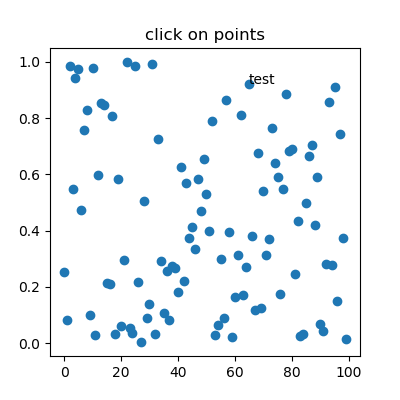

In [79]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.set_title('click on points')

line, = ax.plot(np.random.rand(100), 'o', picker=5)
text = ax.text(0,0,"")
def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    text.set_position((xdata[ind], ydata[ind]))
    text.set_text("test")

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

First example of objectselection

<IPython.core.display.Javascript object>


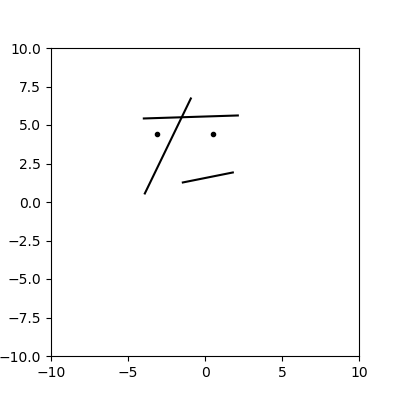

In [7]:
fig, ax = plt.subplots(figsize = (4, 4))
lines = []
points = []
first_point = None


def onclick(event):
        global first_point, lines
        if event.button == 1:
            if first_point:
                new_line = np.array([first_point, [event.xdata, event.ydata]])
                ax.plot([new_line[0,0], new_line[1,0]], [new_line[0,1], new_line[1,1]], color='black')
                lines.append(new_line)
                first_point = None
            else:
                first_point = [event.xdata, event.ydata]
        elif event.button == 3:
                ax.plot(event.xdata, event.ydata, '.', color='black')
                new_point = np.array([event.xdata, event.ydata])
                points.append(new_point)

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_aspect(1)
connection_id = fig.canvas.mpl_connect('button_press_event', onclick)


plt.show()

Combined placing dots and making lines

In [313]:
mat=np.zeros((len(points), len(points)))

pointsArray = np.zeros((len(points),2))

for pointId in points:
    pointsArray[points[pointId][2], :] = points[pointId][:2]

distmat = cdist(pointsArray, pointsArray)

for lineId in lines:
    
    mat[points[lines[lineId][0]][2],points[lines[lineId][1]][2]]= distmat[points[lines[lineId][0]][2],points[lines[lineId][1]][2]]

fig, ax = plt.subplots()
ax.set_xlim(185, 95)
ax.set_ylim(185, 95)
ax.imshow(mat)

mat[points[lines[156][0]][2],points[lines[156][1]][2]]

IndexError: tuple index out of range

In [315]:
tjLines={}
tjPoints = {}
keepLines = {}
color='ko'
first_point=None
picking=False
pointid=0
lineid=0
idOne = -1
idTwo = -1
       
def drawvas():                                        #Draw canvas and Legend
        global fig, ax
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(-40,50)
        ax.set_ylim(-40,40)
        ax.set_aspect(1)
        ax.plot(-37.5, -37.5, 'ko', picker=5, zorder =2)
        ax.plot(-37.5, -35, 'yo', picker=5, zorder =2)
        tjPoints[0] = (-37.5, -37.5, 'ko')
        tjPoints[1] = (-37.5, -35, 'yo')
        
def drawIreland():                                     #Draw points read from .Csv files
    global pointid, idOne, idTwo, lineid
    pointOne = []
    pointTwo = []
    for ant in antpos:
        ax.plot(ant[0], ant[1], color, picker=5, zorder=2)
        tjPoints[pointid] = (ant[0], ant[1], color)
        pointid = pointid+1
    for piket in hulppiketten:
        ax.plot(float(hulppiketten[piket][0]), float(hulppiketten[piket][1]), 'yo', picker=5, zorder=2, markersize=4.5) 
        tjPoints[pointid] = (float(hulppiketten[piket][0]), float(hulppiketten[piket][1]), 'yo')
        pointid = pointid+1
    for hLine in importLines:
        for point in tjPoints:
            if point == int(importLines[hLine][0]):
                pointOne = (tjPoints[point][0], tjPoints[point][1])
                idOne = point
            elif point == int(importLines[hLine][1]):
                pointTwo = (tjPoints[point][0], tjPoints[point][1])
                idTwo = point
            else:
                pass
        ax.plot([pointOne[0], pointTwo[0]], [pointOne[1], pointTwo[1]], color='black', zorder=1)
        tjLines[lineid] = (idOne, idTwo)
        lineid = lineid+1
                                      
def onpick(event):                                    #When you click a point:
    global picking, color, xdata, ydata
    picking = True
    thisline = event.artist
    xdata = thisline.get_xdata()                    #-Saving selected dot's location
    ydata = thisline.get_ydata()                    #-Loop all points looking for blue and red in legend
    if (ydata == -37.5):                        #-if selected point is red dot in legend, set color        
        color='ko'
        picking = False
    elif (ydata == -35):                      #Same for blue
        color='yo'
        picking = False
    else:                                           #-If the dot isn't part of our legend, pick it
        plt.gca().picked_object = thisline
        
def onclick(event):
    global first_point, tjLines, tjPoints, picking, color, xdata, ydata, pointid, lineid, idOne, idTwo
    if (event.button == 1) & (picking):             
        if first_point:                             #- if the selected point is a different point from the one previously
            if [xdata, ydata] != first_point:       #selected, draw a line between the two and add it to lines[]
                for point in tjPoints:
                    if (tjPoints[point][0] == first_point[0]) & (tjPoints[point][1] == first_point[1]): 
                        idOne = point               #- grab Id's of the points you're connecting
                    elif (tjPoints[point][0] == xdata) & (tjPoints[point][1] == ydata):
                        idTwo = point
                    else:
                        pass
                ax.plot([first_point[0], xdata], [first_point[1], ydata], color='black', zorder=1)
                tjLines[lineid] = (idOne, idTwo)
                lineid = lineid+1
                first_point = None
                fig.canvas.draw()
        else:
            first_point = [xdata, ydata]
    elif event.button == 3:                         #-Rightclick places a new point and adds it to points[]
            ax.plot(event.xdata, event.ydata, color, picker=5, zorder=2)
            tjPoints[pointid] = (event.xdata, event.ydata, color)
            pointid = pointid+1
            fig.canvas.draw()
            
def on_key(event):                                  #-Deletes selected point when you press delete
    global first_point, keepLines, keepPoints, tjPoints, tjLines, lineid
    pointOne = []
    pointTwo = []
    if event.key == u'delete':
        for line in tjLines:
            lid = lineid - 1
            if line == lid:
                pass
            else:
                keepLines[line] = (tjLines[line][0], tjLines[line][1])
        tjLines = keepLines
        keepLines = {}
        ax.clear()
        ax.set_xlim(-40,50)
        ax.set_ylim(-40,40)
        ax.set_aspect(1)
        for point in tjPoints:
            ax.plot(tjPoints[point][0], tjPoints[point][1], tjPoints[point][2], picker=5, zorder=2)
        for line in tjLines:
            for point in tjPoints:
                if point == tjLines[line][0]:
                    pointOne = (tjPoints[point][0], tjPoints[point][1])
                elif point == tjLines[line][1]:
                    pointTwo = (tjPoints[point][0], tjPoints[point][1])
                else:
                    pass
            ax.plot([pointOne[0], pointTwo[0]], [pointOne[1], pointTwo[1]], color='black', zorder=1)
        fig.canvas.draw()
        axes.picked_object = None
        first_point = None
            
#drawvas()
#drawIreland()
connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('pick_event', onpick)
cid = fig.canvas.mpl_connect('key_press_event', on_key)
plt.show()

Placing points(and choosing color), placing lines between points, selecting points,
deleting points + every line the point you are deleting is connected to (delete key)

the drawIreland function reads antennas, points, and lines from a .csv and adds them to the plot

In [2]:
def read_lines_csv(lines_csv):
    """
    Reads out how to connect lines from given file location and returns them 
    
    Args:
        lines_csv (str): string with file location of the .csv with all the neccesary information to plot the lines
    
    Returns:
        lines(dict) contains the ID's of the points that this line connects to eachother saved at a custom ID for the line
    """
    import_lines = {}
    with open(lines_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            import_lines[int(row[0])] = (row[1], row[2])
    return import_lines
def read_points_csv(points_csv):
    """
    Reads out points locations from given file location and returns them 
    
    Args:
        points_csv (str): string with file location of the .csv with all the neccesary information on the points
    
    Returns:
        points(dict) contains the x- y- locations and custom ID of all points saved at the point's official number
    """
    dud_lines = ['', 'Hulppiketten graven LBA veld', 'Antenna marking points', 'Point 1: LBA - Cable exit marker', 'NAME', 'ï»¿', 'Point 1: LBA - Cable exit marker,,,,,"Point 2: LBA - Marker 2 (""pikketten boven"")",,,,,"Point 3: LBA - Marker 3 (""pikketten beneden"")",,,,,,,']
    points={}
    with open(points_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if (row[15] not in dud_lines):
                points[row[15]] = float(row[16]), float(row[17])
            if (row[0] not in dud_lines): 
                points[row[0]] = float(row[1]), float(row[2])
    return points
def read_antennas_csv(points_csv, exceptions):
    """
    Reads out only the antennas locations from given file location and returns them 
    
    Args:
        points_csv (str): string with file location
        exceptions (array): array of the exceptional points that you don't want to ignore
    
    Returns:
        points(dict) contains the x- y- locations and custom ID of all antennas saved at the antennas official number
    """
    dud_lines = ['', 'Hulppiketten graven LBA veld', 'Antenna marking points', 'Point 1: LBA - Cable exit marker', 'NAME', 'ï»¿', 'Point 1: LBA - Cable exit marker,,,,,"Point 2: LBA - Marker 2 (""pikketten boven"")",,,,,"Point 3: LBA - Marker 3 (""pikketten beneden"")",,,,,,,']
    excep = exceptions
    points={}
    with open(points_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if (row[15] in excep and row[15] not in dud_lines):
                points[row[15]] = (row[16]), (row[17])
            if (row[0] not in dud_lines): 
                points[row[0]] = (row[1]), (row[2])
    return points
def plot_line(ax, ob):
    """
    draw a line object on the given ax
    
    Args:
        ax: the ax to draw on
        ob: the object to draw
    Returns:
        no return
    """
    x, y = ob.xy
    ax.plot(x, y, linewidth=0.5,color='black',solid_capstyle='round', zorder=1)
def Pardon_points(antennas_csv):
    """
    Calculates for all the antennas in antennas_csv which antennas are further than 75 meters away from LBD1
    
    Args:
        antennas_csv (str): string with the file location
        
    Returns:
        pardon_points(dict): {Point_id : distance to LBD1} for every point that has a distance greater than 75
    """
    pardon_points = {}
    temp_point_id = 0
    temp_line_id = 0
    antenna_points = {}
    direct_lines = {}
    direct_distance = {}
    import_points =  read_antennas_csv(antennas_csv, ['LBD1'])
    for point in import_points:
        if point == 'LBD1':
            antenna_points[point] = (float(import_points[point][0]), float(import_points[point][1]), temp_point_id)
            temp_point_id += 1
        else:
            antenna_points[point] = (float(import_points[point][0]), float(import_points[point][1]), temp_point_id)
            temp_point_id += 1
    for point in antenna_points:
        if point != 'LBD1':
            direct_lines[temp_line_id] = ['LBD1', point]
            temp_line_id+=1
    mat=np.zeros((len(antenna_points), len(antenna_points)))
    pointsArray = np.zeros((len(antenna_points),2))
    for pointId in antenna_points:
        pointsArray[antenna_points[pointId][2], :] = antenna_points[pointId][:2]
    distmat = cdist(pointsArray, pointsArray)
    for lineId in direct_lines:    
        mat[antenna_points[direct_lines[lineId][0]][2],antenna_points[direct_lines[lineId][1]][2]]= distmat[antenna_points[direct_lines[lineId][0]][2],antenna_points[direct_lines[lineId][1]][2]]

    for point in antenna_points:                                            
            if point != 'LBD1':                                         
                dist = scipy.sparse.csgraph.dijkstra(mat)[0, antenna_points[point][2]]
                direct_distance[point] = (dist)
    for point in direct_distance:
        if direct_distance[point] > 75:
            pardon_points[point] = (direct_distance[point])
    return pardon_points
def calcDist(points_csv, lines_csv, start_point):
    """
    Calculate the distance to "start_point" walking through the lines in the given .csv for every point that is in
    the given points .csv
    
    Args:
        points_csv (str): string with file location of the .csv with all the neccesary information on the points
        lines_csv (str): string with file location of the .csv with all the neccesary information on the lines
        start_point(int): point from which the distance should be calculated
    
    Returns:
        distance (dict): dictionary containing for each antenna (e.g. '1101') the distance to the container
        mat(matrix): matrix that is used for distancecalculation(calcScore is intrigued and wants it too)
    """
    dist_points = rp_csv(points_csv)
    dist_lines = rl_csv(lines_csv)
    dist_pid = 0
    distance={}
    for point in dist_points:
        dist_points[point] = dist_points[point][0], dist_points[point][1], dist_pid
        dist_pid+= 1
    mat=np.zeros((len(dist_points), len(dist_points)))
    dist_points_array = np.zeros((len(dist_points),2))
    for pointId in dist_points:
        dist_points_array[dist_points[pointId][2], :] = dist_points[pointId][:2]
    distmat = cdist(dist_points_array, dist_points_array)
    for lineId in dist_lines:
        mat[dist_points[dist_lines[lineId][0]][2],dist_points[dist_lines[lineId][1]][2]]= distmat[dist_points[dist_lines[lineId][0]][2],dist_points[dist_lines[lineId][1]][2]]
    for point in dist_points:                                            
        if point[0] != 'L':                                         
            dist = scipy.sparse.csgraph.dijkstra(mat)[start_point, dist_points[point][2]]
            distance[point] = (dist)
    return (distance, mat)
def calcConnections(points_csv, lines_csv):
    """
    Gives the amount of Piket connections, and the amount of antenna connections for each piket in the given .csv's
    
    Args:
        points_csv (str): string with file location of the .csv with all the neccesary information on the points
        lines_csv (str): string with file location of the .csv with all the neccesary information on the lines
    
    Returns:
        connections(dict): {pointID: piketconnections, antennaconnections} for every piket in the given .csv's
    """
    con_points = rp_csv(points_csv)
    con_lines = rl_csv(lines_csv)
    connections = {}
    for point in con_points:
        if point[0] == 'L':
            piket_connected = 0
            antenna_connected = 0
            for line in con_lines:
                if con_lines[line][0] == point:
                    if con_lines[line][1][0]=='1':
                        antenna_connected += 1
                    else:
                        piket_connected += 1
                elif con_lines[line][1] == point:
                    piket_connected += 1
            connections[point] = [piket_connected, antenna_connected]
    return connections
def calcTurns(points_csv, lines_csv):
    """
    returns the total amount of turns, amount of turns that changed the course of the line for
    less than 40 degrees leading to a piket, amount of turns that changed the course of the line for more than 40 degrees
    leading to a piket, amount of turns that changed the course of the line for less than 40 degrees leading 
    to an antenna, amount of turns that changed the course of the line for more than 40 degrees leading to an antenna,
    amount of turns that were made for a direct connection to an antenna and the total amount of turns that weren't.    
    
    Args:
        points_csv (str): string with file location of the .csv with all the neccesary information on the points
        lines_csv (str): string with file location of the .csv with all the neccesary information on the lines
    
    Returns:
        turns(dict): (turns, <40* turns piket, >40* turns piket, <40* turns antenna, >40* turns antenna, total turns towards
                        antenna, total turns towards piket)
    """
    drift_points = rp_csv(points_csv)
    drift_lines = rl_csv(lines_csv)
    temp_dict_one = {}
    temp_dict_two = {}
    turns = {}
    temp_id = 0
    
    startX = None
    startY = None
    middleX = None
    middleY = None 
    endX = None
    endY = None
    directionOne = None
    directionTwo = None
    lengteO = None
    lengteA = None
    angle_one = None
    angle_two = None
    differencelines = None
    
    for point in drift_points:
        if point[0] == 'L':
            for line in drift_lines:
                if drift_lines[line][1] == point:
                    temp_dict_one[temp_id] = ["start", drift_points[drift_lines[line][0]][0], drift_points[drift_lines[line][0]][1]]
                    temp_id += 1
                    temp_dict_one[temp_id] = ["middle",drift_points[point][0], drift_points[point][1], point]
                    temp_id += 1
                    for line2 in drift_lines:
                        if drift_lines[line2][0] == point:
                            temp_dict_one[temp_id] = ["end", drift_points[drift_lines[line2][1]][0], drift_points[drift_lines[line2][1]][1], drift_lines[line2][1]]
                            temp_id += 1
    
    for turn in temp_dict_one:
        if temp_dict_one[turn][0] == 'start':
            startX = float(temp_dict_one[turn][1]) 
            startY = float(temp_dict_one[turn][2])
        elif temp_dict_one[turn][0] == 'middle':
            middleX = float(temp_dict_one[turn][1]) 
            middleY = float(temp_dict_one[turn][2])
        elif temp_dict_one[turn][0] == 'end':
            endX = float(temp_dict_one[turn][1]) 
            endY = float(temp_dict_one[turn][2])
        if (startX != None) and (middleX != None) and (endX != None):
            if (startX != middleX) and (startY != middleY):
                if ((startX > middleX) and (startY > middleY)) or ((startX < middleX) and (startY < middleY)):
                    lengteA = abs(startY - middleY)
                    lengteO = abs(startX - middleX)
                else:
                    lengteA = abs(startY - middleY)  #AO
                    lengteO = abs(startX - middleX)
                angle_one = abs(math.degrees(math.atan(lengteO / lengteA)))
                if (startX > middleX) and (startY > middleY):
                    directionOne = 'LD'
                elif (startX > middleX) and (startY < middleY):
                    directionOne = 'LU'
                elif (startX < middleX) and (startY > middleY):
                    directionOne = 'RD'
                elif (startX < middleX) and (startY < middleY):
                    directionOne = 'RU'
            else:
                if (startX == middleX) and (startY > middleY):
                    directionOne = 'DOWN'
                if (startX == middleX) and (startY < middleY):
                    directionOne = 'UP'
                if (startX > middleX) and (startY == middleY):
                    directionOne = 'LEFT'
                if (startX < middleX) and (startY == middleY):
                    directionOne = 'RIGHT' 

            if (middleX != endX) and (middleY != endY):
                if ((middleX > endX) and (middleY > endY)) or ((middleX < endX) and (middleY < endY)):
                    lengteA = abs(middleY - endY)
                    lengteO = abs(middleX - endX)
                else:
                    lengteA = abs(middleY - endY) # AO
                    lengteO = abs(middleX - endX)
                angle_two = abs(math.degrees(math.atan(lengteO / lengteA)))
                if (middleX > endX) and (middleY > endY):
                    directionTwo = 'LD'
                elif (middleX > endX) and (middleY < endY):
                    directionTwo = 'LU'
                elif (middleX < endX) and (middleY > endY):
                    directionTwo = 'RD'
                elif (middleX < endX) and (middleY < endY):
                    directionTwo = 'RU'
            else:
                if (middleX == endX) and (middleY > endY):
                    directionTwo = 'DOWN'
                if (middleX == endX) and (middleY < endY):
                    directionTwo = 'UP'
                if (middleX > endX) and (middleY == endY):
                    directionTwo = 'LEFT'
                if (middleX < endX) and (middleY == endY):
                    directionTwo = 'RIGHT'
            
            if (directionOne == 'LEFT') or (directionOne == 'RIGHT') or (directionOne == 'UP') or (directionOne == 'DOWN') or (directionTwo == 'LEFT') or (directionTwo == 'RIGHT') or (directionTwo == 'UP') or (directionTwo == 'DOWN'):
                if directionOne == directionTwo:
                    differencelines = 0
                elif ((directionOne == 'UP') and (directionTwo == 'LEFT')) or ((directionOne == 'UP') and (directionTwo == 'RIGHT')) or ((directionOne == 'LEFT') and (directionTwo == 'UP')) or ((directionOne == 'LEFT') and (directionTwo == 'DOWN')) or ((directionOne == 'DOWN') and (directionTwo == 'LEFT')) or ((directionOne == 'DOWN') and (directionTwo == 'RIGHT')) or ((directionOne == 'RIGHT') and (directionTwo == 'UP')) or ((directionOne == 'RIGHT') and (directionTwo == 'DOWN')):
                    differencelines = 90
                elif ((directionOne == 'UP') and (directionTwo == 'DOWN')) or ((directionOne == 'DOWN') and (directionTwo == 'UP')) or ((directionOne == 'RIGHT') and (directionTwo == 'LEFT')) or ((directionOne == 'LEFT') and (directionTwo == 'RIGHT')):
                    differencelines = 180
                elif (directionOne != 'LEFT') and (directionOne != 'RIGHT') and (directionOne != 'UP') and (directionOne != 'DOWN'):
                    differencelines = angle_one
                else:
                    differencelines = angle_two
            elif directionOne == directionTwo:
                differencelines = abs(angle_one - angle_two)
            elif ((directionOne == 'LD') and (directionTwo == 'RU')) or ((directionOne == 'LU') and (directionTwo == 'RD')) or ((directionOne == 'RD') and (directionTwo == 'LU')) or ((directionOne == 'RU') and (directionTwo == 'LD')):
                differencelines = abs(angle_one + angle_two) + 90
            elif(angle_one != None) and (angle_two != None):
                differencelines = abs(angle_one + angle_two)
            
            temp_dict_two[turn] = [differencelines, temp_dict_one[turn][3], temp_dict_one[turn][0]]
            if temp_dict_one[turn][0] == 'end':
                endX = None
                endY = None
                
    piket_more = 0
    piket_less = 0
    ant_more = 0
    ant_less = 0
    for turn in temp_dict_two:
        if temp_dict_two[turn][1][0] == 'L':
            if temp_dict_two[turn][0] >= 40:
                piket_more += 1
            else:
                piket_less += 1
        else:
            if temp_dict_two[turn][0] >= 40:
                ant_more += 1
            else:
                ant_less += 1
    
    ant_total = ant_more + ant_less
    piket_total = piket_more + piket_less
    total_turns = ant_total + piket_total
    turns['Turns'] = [total_turns, piket_less, piket_more, ant_less, ant_more, ant_total, piket_total]  
        
    return turns
def herrings(pt):
    """
    Give 8 herring locations for inserted antenna location
    
    Args:
        pt: id of the requested point
        
    Returns:
        array of the herring locations
   """
    herrings = []
    oneherring = np.array([[-0.225,0.225],[0.225,0.225],[0.225,-0.225],[-0.225,-0.225]])
    for xoffset in [-1.5+0.225, 0, 1.5-0.225]:
        for yoffset in [-1.5+0.225, 0, 1.5-0.225]:
            if xoffset == 0 and yoffset == 0:
                continue
            offset = np.array([xoffset, yoffset])
            herrings += [Polygon(np.array(pt) + offset + oneherring)]
    return herrings
def calcIntersections(points_csv, lines_csv):
    """
    finds all points where lines intersect with herrings
    
    Args:
        points_csv(str): file location with .csv of points
        lines_csv(str): file location with .csv of lines
    """
    pts = rp_csv(points_csv)
    lines = rl_csv(lines_csv)
    intersections = {}
    intersection_id=0
    for line in lines:
        line = LineString((pts[lines[line][0]], pts[lines[line][1]]))
        for point in pts:
            if point[0] != 'L':
                for her in herrings(pts[point]):
                    if line.intersection(her).length != 0.0:
                        intersections[intersection_id] = [point, pts[point], line.intersection(her).length]
                        intersection_id  += 1
    return intersections
def margin(pt):
    """
    Give margin location for inserted antenna location
    
    Args:
        pt: id of the requested point
        
    Returns:
        array of the margin's xy
    """
    margin = []
    one_margin = np.array([[-1.7,1.7],[1.7,1.7],[1.7,-1.7],[-1.7,-1.7]])
    margin += [Polygon(np.array(pt) + one_margin)]
    return margin
def marginIntersections(points_csv, lines_csv):
    """
    finds all points where lines intersect with the safety margin
    
    Args:
        points_csv(str): file location with .csv of points
        lines_csv(str): file location with .csv of lines
    """
    m_points = rp_csv(points_csv)
    m_lines = rl_csv(lines_csv)
    m_intersections = {}
    intersection_id=0
    for line in m_lines:
        lineid = m_lines[line][1][0]
        line = LineString((m_points[m_lines[line][0]], m_points[m_lines[line][1]]))
        for point in m_points:
            if point[0] != 'L':
                for mar in margin(m_points[point]):
                    if line.intersection(mar).length != 0.0:
                        if lineid == 'L':                     
                            m_intersections[intersection_id] = [point, m_points[point], line.intersection(mar).length]
                            intersection_id  += 1
    return m_intersections
def look_ahead(p, lines_csv):
    """
    Looks at whichs points are directly ahead of the given point in the given list of lines
    
    Args:
        p(str): Id of the point
        lines_csv(str): contains the filelocation where the .csv can be found that contains the lines
    Returns:
        last_one(array): array containing the Id's of the points that are ahead of p
    """
    rec_lines = rl_csv(lines_csv)
    last_one = []
    for line in rec_lines:
        if (rec_lines[line][0] == p) and (rec_lines[line][1][0] == 'L'):
            last_one += [rec_lines[line][1]]
    return last_one
def count_ahead(p, points_csv, lines_csv):
    """
    recursively looks ahead of the given points untill it reaches the end of the line and then counts all
    the antenna connections that are ahead of this point
    
    Args: 
        p(str): Id of the point
        points_csv(str): contains the filelocation where the .csv can be found that contains the points 
        lines_csv(str): contains the filelocation where the .csv can be found that contains the lines
    Returns:
        total(int): accumulated total of all the antennas that are indirectly connected to p
                    note: does not contain the antenna's directly connected to p
    
    """
    rec_con = calcConnections(points_csv, lines_csv)
    total = 0
    if rec_con[p][0] > 1:
        for ant in look_ahead(p, lines_csv):
            total += count_ahead(ant, points_csv, lines_csv)
            total += rec_con[ant][1]
    return total
def calcScore(points_csv, lines_csv, start_point):
    """
    Calculate the amount of money that building this layout would cost.
    
    Args:
        points_csv (str): string with file location of the .csv with all the neccesary information on the points
        lines_csv (str): string with file location of the .csv with all the neccesary information on the lines
        start_point(int): integer with information that calcDist needs to know.
        
    Returns:
        score (float): score for the given layout measured in euros
    """
    score_lines = rl_csv(lines_csv)
    score_points = rp_csv(points_csv)
    #pardon = Pardon_points(points_csv)
    connections = calcConnections(points_csv, lines_csv)
    turns = calcTurns(points_csv, lines_csv)
    s_distance = calcDist(points_csv, lines_csv, start_point)[0]
    matrix = calcDist(points_csv, lines_csv, start_point)[1]
    score_pid = 0
    for point in score_points:
        score_points[point] = score_points[point][0], score_points[point][1], score_pid
        score_pid+= 1
    onefifteens = 0
    eightyfives = 0
    #pardonpoints = 0
    piketten = 0
    antennas = 0
    foul = 0
    invalid = False
    trench_size = 0
    total_coax = 0
    for line in score_lines:
        trench_size += scipy.sparse.csgraph.dijkstra(matrix)[score_points[score_lines[line][0]][2], score_points[score_lines[line][1]][2]]
    for d in s_distance:
        total_coax += s_distance[d]
        if s_distance[d] >= 75:
            onefifteens += 1
        elif s_distance[d] >= 105:
            invalid = True
        else:
            eightyfives += 1
    for p in score_points:
        if p[0] == 'L':
            piketten += 1
        else:
            antennas += 1
    #for pardonid in pardon:
    #    pardonpoints +=1
    for piket in connections:
        if connections[piket][1] == 0 :
            foul += 1
    if invalid:
        score = 0
    else:
        #score = (trench_size) #, total_coax, [piketten, antennas], [eightyfives, onefifteens], foul, turns])#[pardonpoints, eightyfives, onefifteens], foul, turns])
        score = (str(int((trench_size * 20) + (piketten*0.35) + (eightyfives * 170) + (onefifteens * 230))) + " euroo'tjes")  # - pardonpoints) * 230))) + " euroo'tjes")
    return score

In [3]:
def drawLOFAR(line_id, point_id, lines_csv, points_csv):
    """
    Draw points and lines read from .Csv files and adds them to points{} and lines{}
    
    Args:
        lineid (int): simple int that's always 1 greater than the id of the last added line
        pointid (int): simple int that's always 1 greater than the id of the last added point
        lines_csv (string): string with the file name of the .csv where all line connections can be found
        points_csv (string): string with the file name of the .csv where all point locations and names can be found
    
    Returns:
        points(dict) contains the x- y- locations and custom ID of all points saved at the point's official number
        lines(dict) contains the ID's of the points that this line connects to eachother saved at a custom ID for the line
    """
    import_lines = read_lines_csv(lines_csv)
    import_points =  read_points_csv(points_csv)
    id_one = None
    id_two = None
    for point in import_points:
        if point[0] != 'L':
            ax.plot(float(import_points[point][0]), float(import_points[point][1]), 'w.', picker=5, zorder=1, markersize = 3)
            points[point] = (float(import_points[point][0]), float(import_points[point][1]), point_id)
            point_id += 1
        else:
            ax.plot(float(import_points[point][0]), float(import_points[point][1]), 'yo', picker=5, zorder=0.01, markersize=1) 
            points[point] = (float(import_points[point][0]), float(import_points[point][1]), point_id)
            point_id += 1
    for line in import_lines:
        for point in points:
            if point == import_lines[line][0]:
                id_one = point
            elif point == import_lines[line][1]:
                id_two = point
            else:
                pass
        ax.plot([points[id_one][0], points[id_two] [0]], [points[id_one][1], points[id_two][1]], 'darkorchid', zorder=6, linewidth=0.5)
        lines[line_id] = (id_one, id_two)
        line_id += 1
    for point in points:
        if point[0] == '1':
            ax.add_artist(Rectangle(((points[point][0] - 1.5), (points[point][1] - 1.5)), width=3, height=3, facecolor='lightgray', zorder=0.5))
            ax.add_artist(Rectangle(((points[point][0] - 1.7), (points[point][1] - 1.7)), width=3.4, height=3.4, facecolor='gray', zorder=0))
            #ax.add_artist(Circle(points[point], radius=1.9, facecolor='Orange', zorder=2))
            ax.add_artist(Circle(points[point], radius= 0.25, facecolor='white', zorder=10))           
    return lines, points
def drawAnt(point_id, points_csv, exceptions):
    """
    Draw only the antennas from .Csv files and add them to points{}
    
    Args:
        pointid (int): simple int that's always 1 greater than the id of the last added point
        points_csv (string): string with the file name of the .csv where all antenna locations and names can be found
        exceptions (array): array of the exceptional points that you don't want to ignore
    
    Returns:
        points(dict) contains the x- y- locations and custom ID of all antennas saved at the antennas official number 
    """
    points = {}
    import_points =  read_antennas_csv(points_csv, exceptions)
    for point in import_points:
        if point in exceptions:
            ax.plot(float(import_points[point][0]), float(import_points[point][1]), 'yo', picker=5, zorder=3, markersize = 4.5)
            points[point] = (float(import_points[point][0]), float(import_points[point][1]), point_id)
            point_id += 1
        else:
            ax.plot(float(import_points[point][0]), float(import_points[point][1]), 'w', picker=5, zorder=1, markersize = 3)
            points[point] = (float(import_points[point][0]), float(import_points[point][1]), point_id)
            point_id += 1
            ax.add_artist(Rectangle(((float(import_points[point][0]) - 1.5), (float(import_points[point][1]) - 1.5)), width=3, height=3, facecolor='gray', zorder=0))
            #ax.add_artist(Circle(import_points[point], radius=2.4, facecolor='Orange', zorder=2))
            ax.add_artist(Circle((float(import_points[point][0]), float(import_points[point][1])), radius= 0.25, facecolor='white', zorder=4))
    return points

<IPython.core.display.Javascript object>


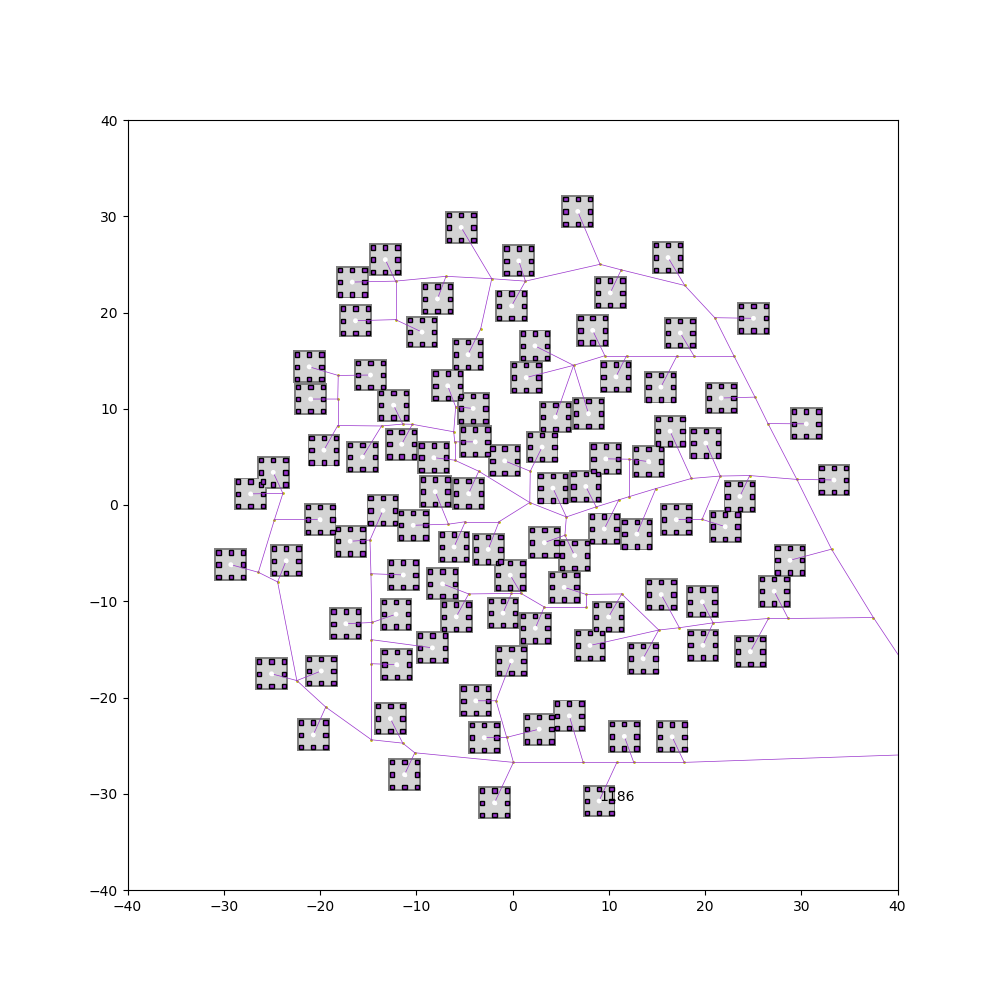

In [259]:
lines={}
points={}
keep_lines={}
point_id=0
line_id=0
first_point=None
antpiket_csv = 'antPiketIreland.csv'
lijnen_csv = 'lijnenIreland.csv'

def drawvas():                                        
    global fig, ax
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect(1)
    
def visuals():
    for point in points:
        #if point == 'LBD1':
            #ax.add_artist(Circle(points[point], radius=75, facecolor='black', alpha=0.1))
        if point[0] == 'L':
            ax.add_artist(Circle(points[point], radius = 0.2, facecolor='Yellow', alpha=1, zorder=8))
                                      
def onpick(event):                                  
    global xdata, ydata
    text = ax.text(0,0,"")
    this_line = event.artist
    xdata = this_line.get_xdata()                    
    ydata = this_line.get_ydata() 
    ind = event.ind
    text.set_position((xdata[ind], ydata[ind]))
    for point in points:
        if (xdata == points[point][0]) & (ydata == points[point][1]):
            text.set_text(point)
                                                      
def onclick(event):
    global first_point, lines, points, xdata, ydata, point_id, line_id, distance
    id_one = 0
    id_two = 0                                                                         
    if first_point:                                                                         
        if [xdata, ydata] != first_point:                                                     
            for point in points:
                if (points[point][0] == first_point[0]) & (points[point][1] == first_point[1]): 
                    id_one = point               
                elif (points[point][0] == xdata) & (points[point][1] == ydata):
                    id_two = point                                                             
                else:                                                                         
                    pass                                                                      
            ax.plot([first_point[0], xdata], [first_point[1], ydata], 'darkorchid', linewidth=0.5, zorder=3)
            lines[line_id] = (id_one, id_two,)
            line_id += 1                                                                       
            first_point = None
            distance = calcDist(points, 0)
    else:
        first_point = [xdata, ydata]
    
drawvas()    #teken canvas

pts = read_points_csv(antpiket_csv)
for p in pts:
    if p[0] != 'L':
        for polygon in herrings(pts[p]):
            ax.add_patch(descartes.PolygonPatch(polygon,  fc='darkorchid'))

drawLOFAR(line_id, point_id, lijnen_csv, antpiket_csv)
#drawAnt(point_id, antpiket_csv, ['LBD1'])

point_id = len(points)
line_id = len(lines)
#score = calcScore(antpiket_csv, lijnen_csv, 0,)

#visuals()    #mooie dingen
                                    
connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

### notes

Problems MSP:
    * Disregards antenna safety margin
    * Does not care about distance from startpoint, just distance to closest point
    
Potentional problems Steinertree:
    * Only creates Steinerpoints when it makes the tree smaller, so it will also be connecting antennas
    * Disregards antenna safety margin
    * Does not care about distance from startpoint, just distance to closest point

In [124]:
def toFormatAnt(antenna_csv, piket, file):
    """
    Writes the positions of all the antennas in the given csv to the right .text format for Geosteiner 
    like:
        0 1
        1 1
        0 0
        1 0
    
    Args:
        antenna_csv: file location for the .csv file that contains the antennas
        piket: The first piket, point 1, cablebox
        file: The name for the file you'd like to write the values to
    Returns:
        the locations of the antennas in a text file
    """
    wrongdict = read_antennas_csv(antenna_csv, piket)
    file = open(file,'w')
    for point in wrongdict:
        file.write(wrongdict[point][0] + ' ')
        file.write(wrongdict[point][1] + '\n')
    file.close()

In [125]:
def toFormatField(points_csv, file):
    """
    Writes the positions of all the point in the given csv to the right .text format for Geosteiner 
    like:
        0 1
        1 1
        0 0
        1 0
    
    Args:
        antenna_csv: file location for the .csv file that contains the point
        file: The name for the file you'd like to write the values to
    Returns:
        the locations of the points in a text file
    """
    wrongdict = read_points_csv(points_csv)
    file = open(file,'w')
    for point in wrongdict:
        file.write(str(wrongdict[point][0]) + ' ')
        file.write(str(wrongdict[point][1]) + '\n')
    file.close()

In [4]:
def rl_csv(lines_csv):
    """
    reads csv created by writetoCSV into dict lines
            '1', 10, 20
            '2', 11, 21
            ...
    
    Args:
        lines_csv: filename of .csv to read
        
    Rtrns:
        liness(dict): dict with lines like: {line id: (first point id, second point id)}
    """
    lines={}
    lineid = 0
    with open(lines_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV: 
                lines[row[0]] = (row[1], row[2])
                lineid+=1
    return lines

In [679]:
def rp_csv(points_csv):
    """
    reads csv created by writetoCSV into dict points
                'LBD01', 10, 20
                '1101', 10, 21
                ...
    Args:
        points_csv: filename of .csv to read
        
    Rtrns:
        points(dict): dict with points like: {id: (x, y)}
    """
    points={}
    with open(points_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV: 
                points[row[0]] = float(row[1]), float(row[2])
    return points

In [74]:
def toLOFARCSV(points, lines, ptsfile, lnsfile):
    """
    Writes a set of points and lines to two .csv files like:
    ptsfile:
            'LBD12',19,20
            'LBD13',13,14
    lnsfile:
            'LBD12','LBD13'
            'LBD14','LBD15'
    Args:
        points(dict): dict of points {id: (x, y)}
        lines(dict): dict of lines {id: (id of first point, id of second point)}
        ptsfile(str): filename to write points csv to
        lnsfile(str): filename to write lines csv to
    """
    pfile = open(ptsfile,'w')
    lfile = open(lnsfile,'w')
    for point in points:
        pfile.write(str(point) + ',')
        pfile.write(str(points[point][0]) + ',')
        pfile.write(str(points[point][1]) + '\n')
    for line in lines:
        lfile.write(str(line) + ',')
        lfile.write(str(lines[line][0]) + ',')
        lfile.write(str(lines[line][1]) + '\n')
    pfile.close()
    lfile.close()

In [129]:
def anten(points_csv, exceptions):
    """
    Reads out only the antennas locations from given file location and returns them 
    
    Args:
        points_csv (str): string with file location
        exceptions (array): array of the exceptional points that you don't want to ignore
    
    Returns:
        points(dict) contains the x- y- locations and custom ID of all antennas saved at the antennas official number
    """
    dud_lines = ['', 'Hulppiketten graven LBA veld', 'Antenna marking points', 'Point 1: LBA - Cable exit marker', 'NAME', 'ï»¿', 'Point 1: LBA - Cable exit marker,,,,,"Point 2: LBA - Marker 2 (""pikketten boven"")",,,,,"Point 3: LBA - Marker 3 (""pikketten beneden"")",,,,,,,']
    excep = exceptions
    points={}
    with open(points_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if (row[15] in excep and row[15] not in dud_lines):
                points[row[15]] = float(row[16]), float(row[17])
            if (row[0] not in dud_lines): 
                points[row[0]] = float(row[1]), float(row[2])
    return points

<IPython.core.display.Javascript object>


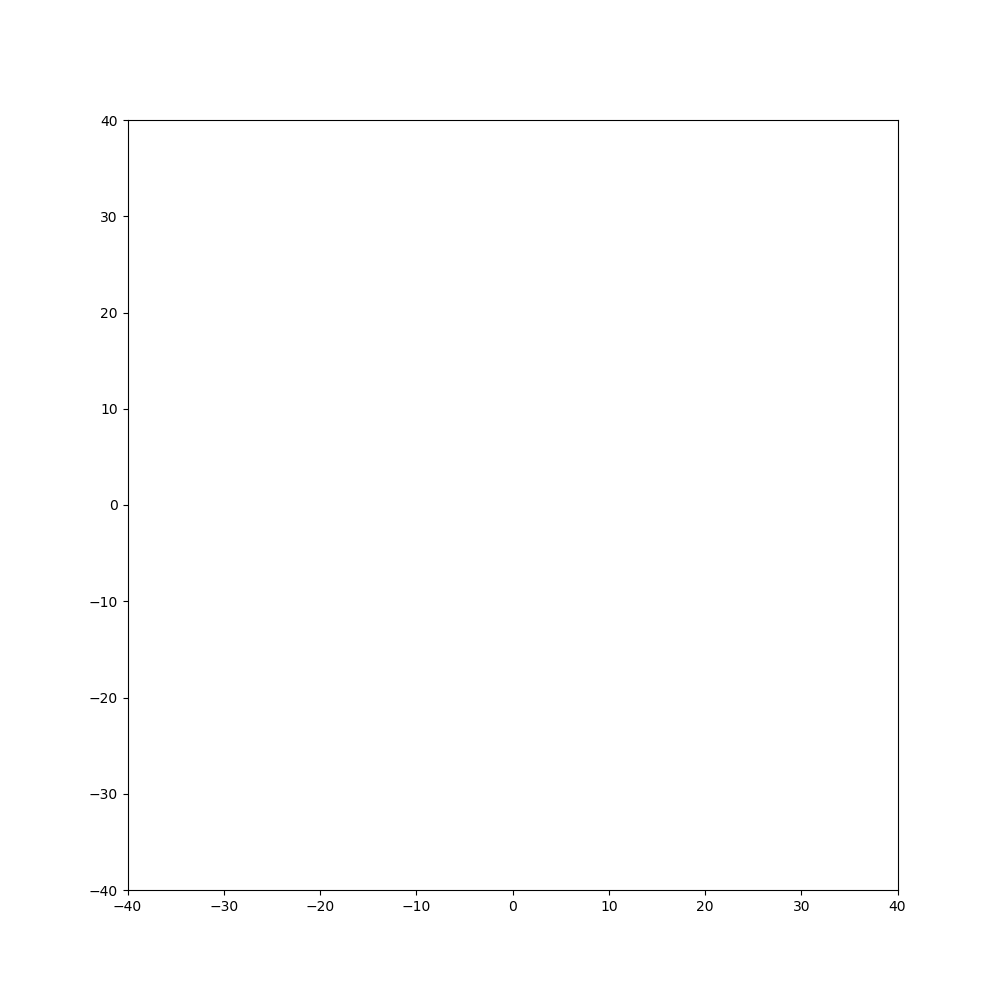

NameError: name 'ant' is not defined

In [255]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_aspect(1)
widthrec=3
heightrec=3

for p in ant:
    if p[0] == 'L':
        pointid = (int(p[3])*1000 + int(p[4])*100 + int(p[5])*10 + int(p[6]) + 1)
for l in ls:
    lineid = (int(l) + 1)
        
first_point=None
idOne=-1
idTwo=-1

def onpick(event):                                  
    global xdata, ydata
    text = ax.text(0,0,"")
    this_line = event.artist
    xdata = this_line.get_xdata()                    
    ydata = this_line.get_ydata() 
    ind = event.ind
    text.set_position((xdata[ind], ydata[ind]))
    for point in ant:
        if (xdata == ant[point][0]) & (ydata == ant[point][1]):
            text.set_text(point)

def onclick(event):
    global first_point, ls, ant, xdata, ydata, pointid, lineid, idOne, idTwo
    if event.button == 3:
        ax.plot(event.xdata, event.ydata, 'y.', picker=5)
        ant[('LBD' + str(pointid))] = (event.xdata, event.ydata)
        pointid = pointid+1
        fig.canvas.draw()
    elif event.button == 1:
        if first_point:
            ax.plot([first_point[0], xdata], [first_point[1], ydata], color='black', linewidth=0.5, zorder=0.5)
            for point in ant:
                if ant[point][0] == first_point[0] and ant[point][1] == first_point[1]:
                    idOne = point
                if xdata == ant[point][0] and ydata == ant[point][1]:
                    idTwo = point
            ls[lineid] = (idOne, idTwo)
            lineid+=1
            first_point = None
        else:
            first_point = (xdata, ydata)


def on_key(event):                                 
    global first_point, ant, ls, lineid
    if event.key == u'delete':
        keepLines = {}
        keepPoints = {}
        throwawayPoints={}
        for p in ant:
            if (ant[p][0] == xdata) and (ant[p][1] == ydata):
                throwawayPoints[p] = ant[p]
            else:
                keepPoints[p] = ant[p]
        for l in ls:
            if (ls[l][0] in throwawayPoints) or (ls[l][1] in throwawayPoints):
                pass
            else:
                keepLines[l] = ls[l]
        ls= keepLines
        ant= keepPoints
        ax.clear()
        ax.set_xlim(-40,40)
        ax.set_ylim(-40,40)
        ax.set_aspect(1)

        for p in ant:
            if p[0] != 'L':
                ax.plot(ant[p][0], ant[p][1], 'k.', picker=5)
                ax.add_artist(Circle((ant[p][0], ant[p][1]), radius=(math.sqrt(math.pow(widthrec,2) + math.pow(heightrec,2))/2), facecolor='darkorchid', zorder=0))
            else:
                ax.plot(ant[p][0], ant[p][1], 'y.',picker=5)
        for l in ls:
            ax.plot([ant[ls[l][0]][0], ant[ls[l][1]][0]], [ant[ls[l][0]][1], ant[ls[l][1]][1]], color='black', linewidth=0.5, zorder=0.5)

        fig.canvas.draw()
        first_point=None

connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('pick_event', onpick)
cid = fig.canvas.mpl_connect('key_press_event', on_key)
plt.show()

for a in ant:
    if a[0] != 'L':
        ax.plot(ant[a][0], ant[a][1], 'k.', picker=5)
        ax.add_artist(Circle((ant[a][0], ant[a][1]), radius=(math.sqrt(math.pow(widthrec,2) + math.pow(heightrec,2))/2), facecolor='darkorchid', zorder=0))
    else:
        ax.plot(ant[a][0], ant[a][1], 'y.', picker=5)
for l in ls:
    ax.plot((ant[ls[l][0]][0], ant[ls[l][1]][0]), (ant[ls[l][0]][1], ant[ls[l][1]][1]), color='black', linewidth=0.5, zorder=0.1)

In [24]:
def read_NMS_pts(ptscsv):
    pts = {}
    dud_lines = ['', 'NAME', 'STATION-P', 'STATION-Q', 'STATION-R', 'NAME;STATION-P;STATION-Q;STATION-R']
    gud_chars = ['M', 'D', 'L', 'Q']
    with open(ptscsv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if (row[0][0] in gud_chars and row[0] not in dud_lines):
                pts[row[0]] = float(row[1]), float(row[2])

    return pts

In [25]:
def read_layout(layout):
    pts = {}
    with open(layout) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0][0] == 'D':
                pts[row[0]] = float(row[1]), float(row[2])
            if row[0][0] == 'T':
                pts[row[0]] = row[1], row[2]
            if row[0][0] == 'U':
                pts[row[0]] = int(row[1]), int(row[2])          
    return pts

<IPython.core.display.Javascript object>


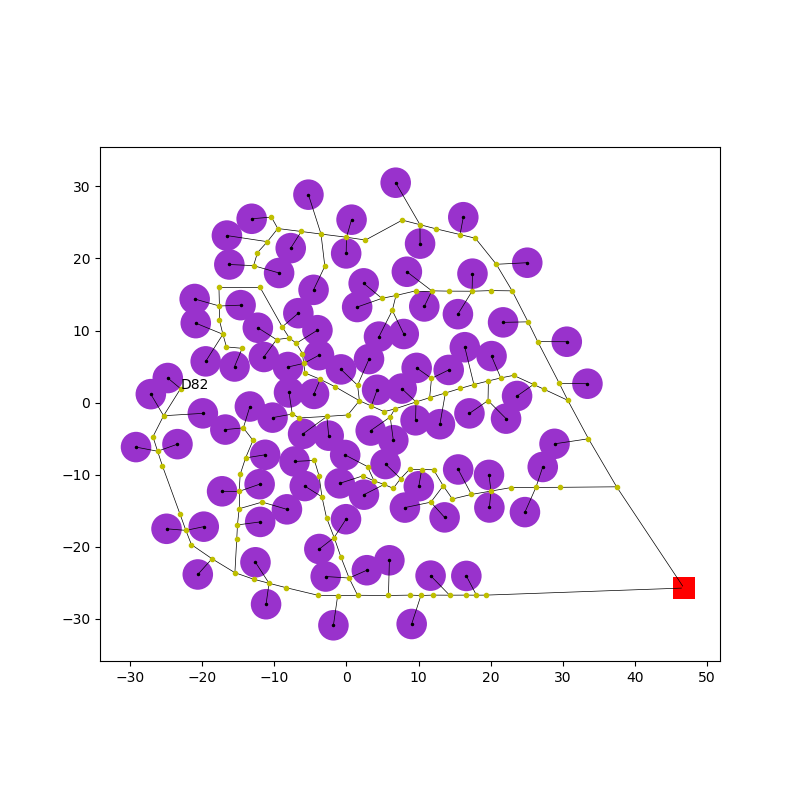

In [473]:
minx=999
maxx=-999
miny=999
maxy=-999
first_point=None
idOne=-1
idTwo=-1
widthrec=3
heightrec=3

fig, ax = plt.subplots(figsize=(8, 8))
        
def onpick(event):                                  
    global xdata, ydata
    text = ax.text(0,0,"")
    this_line = event.artist
    xdata = this_line.get_xdata()                    
    ydata = this_line.get_ydata() 
    ind = event.ind
    text.set_position((xdata[ind], ydata[ind]))
    for point in layout:
        if (xdata == layout[point][0]) & (ydata == layout[point][1]):
            text.set_text(point)
            

def onclick(event):
    global first_point, layout, points, xdata, ydata, pointid, lineid, idOne, idTwo
    if event.button == 3:
        ax.plot(event.xdata, event.ydata, 'y.', picker=5)
        layout[('D' + str(pointid))] = (event.xdata, event.ydata)
        pointid = pointid+1
    #if event.button == 3:
    #    if first_point:
    #        ax.plot([first_point[0], xdata], [first_point[1], ydata], color='black', linewidth=0.5, zorder=0.5)
    #        for point in points:
    #            if points[point][0] == first_point[0] and points[point][1] == first_point[1]:
    #                idOne = point
    #            if xdata == points[point][0] and ydata == points[point][1]:
    #                idTwo = point
    #        for point in layout:
    #            if point[0] == 'D':    
    #                if layout[point][0] == first_point[0] and layout[point][1] == first_point[1]:
    #                    idOne = point
    #                if xdata == layout[point][0] and ydata == layout[point][1]:
    #                    idTwo = point
    #        layout['T'+ str(lineid)] = (idOne, idTwo)
    #        lineid+=1
    #        first_point = None
    #    else:
    #        first_point = (xdata, ydata)

connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

for point in points:
    if point[0] == 'M' or point[0] == 'L':
        ax.plot(points[point][0], points[point][1], 'k.', picker=5, markersize=3)
        #ax.add_artist(Rectangle(((float(points[point][0]) - 1.5), (float(points[point][1]) - 1.5)), width=3, height=3, facecolor='gray', zorder=0))
        ax.add_artist(Circle((points[point][0], points[point][1]), radius=(math.sqrt(math.pow(widthrec,2) + math.pow(heightrec,2))/2), facecolor='darkorchid', zorder=0))
    if point[0] == 'Q':
        ax.plot(points[point][0], points[point][1], 'r.', picker=5)
        ax.add_artist(Rectangle(((float(points[point][0]) - 1.5), (float(points[point][1]) - 1.5)), width=3, height=3, facecolor='red', zorder=0))

for l in layout:
    if l[0] == 'D':
        ax.plot(layout[l][0], layout[l][1], 'y.', picker=5)
    
    elif l[0] == 'T':
        if layout[l][0][0] == 'D':
            hangx = layout[layout[l][0]][0]
            hangy = layout[layout[l][0]][1]
        else:
            hangx = points[layout[l][0]][0]
            hangy = points[layout[l][0]][1]
        if layout[l][1][0] == 'D':
            mangx = layout[layout[l][1]][0]
            mangy = layout[layout[l][1]][1]
        else:
            mangx = points[layout[l][1]][0]
            mangy = points[layout[l][1]][1]
        ax.plot((hangx, mangx), (hangy, mangy), color='black', linewidth=0.5, zorder=0.5)
        
for point in points:
        if points[point][0] < minx:
            minx = points[point][0]
        if points[point][0] > maxx:
            maxx = points[point][0]
        if points[point][1] < miny:
            miny = points[point][1]
        if points[point][1] > maxy:
            maxy = points[point][1]

ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)
ax.set_aspect(1)

In [472]:
points=centerfield('Backup Buitenlandse stations/ie613.csv', 0)#read_NMS_pts('th618.csv')#
layout=centerlayout('a/layout613.csv', 0)#read_layout('layout618.csv')#
pointid=72
lineid=0

In [89]:
rotate_origin((-35,35), np.radians(350))

(-40.54595757376985, 28.39058513708472)

In [1777]:
for p in layout:
    if p[0] == 'D':
        layout[p] = layout[p][0]-0.05, layout[p][1]

In [26]:
def layoutmatrix(points, layout, start_point):
    """
    creates a matrix based on points and a layout and a dictionary with the distance for every point to start_point.
    
    Args:
        points(dict): Dict containing the origin of all cables, and all antenna positions.
        layout(dict): Dict containing all points and lines that the path consists of.
        start_point(int) : 0, if the cablehouse is set as the first of points.
    Rtrns:
        distance(dict): dict with distances for every point.
        mat: matrix based on points and layout.
    """
    dist_pid = 0
    dist_points = {}
    dist_lines = {}
    distance={}
    for point in points:
        if point[0] != 'R':
            dist_points[point] = points[point][0], points[point][1], dist_pid
            dist_pid+= 1
    for point in layout:
        if point[0] == 'D':
            dist_points[point] = layout[point][0], layout[point][1], dist_pid
            dist_pid+= 1
    for line in layout:
        if line[0] == 'T':
            dist_lines[line] = layout[line][0], layout[line][1]
    mat=np.zeros((len(dist_points), len(dist_points)))
    dist_points_array = np.zeros((len(dist_points),2))
    for pointId in dist_points:
        dist_points_array[dist_points[pointId][2], :] = dist_points[pointId][:2]
    distmat = cdist(dist_points_array, dist_points_array)
    for lineId in dist_lines:
        mat[dist_points[dist_lines[lineId][0]][2],dist_points[dist_lines[lineId][1]][2]]= distmat[dist_points[dist_lines[lineId][0]][2],dist_points[dist_lines[lineId][1]][2]]
    for point in dist_points:
        if point[0] != 'D':
            dist = scipy.sparse.csgraph.dijkstra(mat)[start_point, dist_points[point][2]]
            distance[point] = (dist)
    return (distance, mat)
def trenchtot(points, layout, point):
    """
    Calculates the total meters of digging that has been done for given field.
    
    Args:
        points(dict): Dict containing the origin of all cables, and all antenna positions.
        layout(dict): Dict containing all points and lines that the path consists of.
        point(int): pointid of the cable origin (supposed to be on 0).
    Returns:
        (float) total trenches in meters.
    """
    processedlines = {}
    pid = 0
    pointsids = {}
    trenchtot = 0
    matrix = layoutmatrix(points, layout, point)[1]

    for point in points:
        if point[0] == 'Q' or point[0] == 'M':
            pointsids[point] = points[point][0], points[point][1], pid
            pid+=1
    for l in layout:
        if l[0] == 'D':
            pointsids[l] = layout[l][0], layout[l][1], pid
            pid+=1

    for l in layout:
        if l[0] == 'T':
            for p in processedlines:
                if (layout[l][0] == processedlines[p][0] and layout[l][1] == processedlines[p][1]) or (layout[l][0] == processedlines[p][1] and layout[l][1] == processedlines[p][0]):
                    trenchtot -= scipy.sparse.csgraph.dijkstra(matrix)[pointsids[layout[l][0]][2], pointsids[layout[l][1]][2]]
            trenchtot += scipy.sparse.csgraph.dijkstra(matrix)[pointsids[layout[l][0]][2], pointsids[layout[l][1]][2]]
            processedlines[l] = layout[l][0], layout[l][1]
    return trenchtot
def cablelen(points, layout, point):
    """
    Calculates amount of cables that are long and short.
    
    Args:
        points(dict): Dict containing the origin of all cables, and all antenna positions.
        layout(dict): Dict containing all points and lines that the path consists of.
        point(int): pointid of the cable origin (supposed to be on 0).
    Returns:
       (int) amount short cables, (int) amount long cables.
    """
    distances = layoutmatrix(points, layout, point)[0]
    short=0
    long=0
    
    for d in distances:
        if d[0] != 'D':
            if distances[d] > 75:
                long+=1
            else:
                short+=1
    return short, long
def cost(points, layout):
    """
    Calculates € cost of a LOFAR field.
    
    Args:
        points(dict): Dict containing the origin of all cables, and all antenna positions.
        layout(dict): Dict containing all points and lines that the path consists of.
    Returns:
        (int) Calculated value the field will be costing based on €.
    """
    c= cablelen(points, layout, 0)
    t= trenchtot(points, layout, 0)
    
    return(int(c[0]*170 + c[1]*230 + t*20))

In [27]:
def get_rad(points_csv):
    """
    only reads the radians given in a csv as: 
                                R0 : {rad} : 0
    Args:
        points_csv(string): file name of a point set.
    Rtrns:
        rad(int): The integer that was read from the given .csv file. 
    """
    with open(points_csv) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if (row[0][0] == 'R'):
                rad = int(row[1])
    return rad

In [28]:
def centerfield(points_csv, radians):
    """
    Changes given field to be centered around 'M0' at 0, 0. Then rotates the field clockwise.
    
    Args:
        points_csv(string): file name of a pointset.
        radians: Amount of degrees the field is to be rotated clockwise.
    Rtrns:
        points(dict): The rotated field.
    """
    rad = np.radians(radians)
    #static = ['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6']
    points = read_NMS_pts(points_csv)
    
    #x = points['M0'][0]
    #y = points['M0'][1]
    #for p in points:
    #    points[p] = (points[p][0]-x, points[p][1]-y)
    
    for p in points:
        #if p not in static:
        pon = points[p]
        a = rotate_origin(pon, rad)
        points[p] = a 
    return points

In [29]:
def rotate_origin(xy, radians):
    """
    Rotate a point around the origin (0, 0).
    
    Args:
        xy: X and Y cordinates like (x, y).
        radians: np.radians(degrees rotation).
    Returns:
        xx: new x.
        yy: new y.
    """
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [30]:
def centerlayout(layout_csv, radians):
    """
    Rotates a layout given amount of degrees (rotates around 0,0).
    
    Args:
        layout_csv(string): file name of a layout.
        radians: amount of degrees the field is to be rotated.
    Rtrns:
        points(dict): The rotated layout.
    """
    rad = np.radians(radians)
    points = read_layout(layout_csv)
    
    for p in points:
        if p[0] == 'D':
            pon = points[p]
            a = rotate_origin(pon, rad)
            points[p] = a 
    return points

In [57]:
def runlayouts(pts):
    """
    Checks for the given antenna-set which layouts could potentially work. Then tries every possible loadout and saves the
    loadout with the lowest cost.
    
    Args:
        Pts(dict): dict containing 'Q1' as cableorigin, 'M0' - 'M95' as antennas and 'R0' as rotation.
    Rtrns:
        layout(dict): the layout that gave the best result paired with pts.
    """
    location = "a/"
    layouts = [[location + 'layout602.csv'], [location + 'layout603.csv'], [location + 'layout604.csv'], 
               [location + 'layout605.csv'], [location + 'layout606.csv'], [location + 'layout607.csv'],
               [location + 'layout608.csv'], [location + 'layout609.csv'], [location + 'layout610.csv'], 
               [location + 'layout611.csv'], [location + 'layout612.csv'], [location + 'layout613.csv'],
               [location + 'layout614.csv'], [location + 'layout615.csv'], [location + 'layout616.csv'], 
               [location + 'layout617.csv'], [location + 'layout618.csv'], [location + 'layout619.csv'],
               [location + 'layout620.csv'], [location + 'layout621.csv'], [location + 'layout622.csv'],
               [location + 'layout623.csv']]
    
    
              #[['layout005.csv'], ['layout007.csv'], ['layout406.csv'],['layout028.csv'],
              #['layout011.csv'], ['layout003.csv'], ['layout032.csv'], ['layout021.csv'],
              #['layout026.csv'], ['layout001.csv'], ['layout004.csv'], ['layout501.csv'],
              #['layout409.csv'], ['layout017.csv'], ['layout024.csv'], ['layout002.csv']]
    
    bestcost = 999999
    costs=[]
    bestlayout = ""
    
    for l in layouts:
        rad = get_rad(l[0])
        zero = 360 - rad
        lay=centerlayout(l[0], zero)
        
        c = cost(pts, lay)
        costs.append(c)
        if c < bestcost:
            bestcost = c
            bestlayout = l[0]
    return bestcost, bestlayout, costs

In [32]:
def findlayout(points_csv):
    """
    finds the best (currently known) layout for the given set of antennas.
    
    Args:
        points_csv like:    Q1, x, y
                            M0, x, y
                            M1, x, y
                            ........
                            R1, rad, 0
        where q is the cablehouse/point of origin,
        where m is an antenna,
        where r is degrees this field is rotated.
    Rtrns:
        plot of points with best layout, name of best layout, and cost for reference.
    """    
    radpts = get_rad(points_csv)
    zerop = 360-radpts
    points=centerfield(points_csv, zerop)
    
    result = runlayouts(points)
    radlay = get_rad(result[1])
    
    if radlay > radpts:
        raddiff = 360-radlay + radpts
    elif radpts > radlay:
        raddiff = radpts - radlay
    else:
        raddiff = 0
    
    points=centerfield(points_csv, 0)
    lay=centerlayout(result[1], raddiff)
    
    #end = fixherrings(points, lay)
    #lay=cleanup(lay)
    drawfield(points,lay)
    return result
    #return points, lay

In [33]:
def drawfield(points, lay):
    minx=999
    maxx=-999
    miny=999
    maxy=-999
    fig, ax = plt.subplots(figsize=(8, 8))
    for point in points:
        if point[0] == 'M' or point[0] == 'L':
            ax.plot(points[point][0], points[point][1], 'k.', markersize=3)
            ax.add_artist(Rectangle(((float(points[point][0]) - 1.5), (float(points[point][1]) - 1.5)), width=3, height=3, facecolor='lightgray', zorder=0))
            for polygon in herrings(points[point]):
                ax.add_patch(descartes.PolygonPatch(polygon,  fc='darkorchid'))
        if point[0] == 'Q':
            ax.plot(points[point][0], points[point][1], 'r.')
            ax.add_artist(Rectangle(((float(points[point][0]) - 1.5), (float(points[point][1]) - 1.5)), width=3, height=3, facecolor='red', zorder=0)) 
    
    for l in lay:
        if l[0] == 'D':
            ax.plot(lay[l][0], lay[l][1], 'y.', markersize=3)
        elif l[0] == 'T':
            if lay[l][0][0] == 'D':
                fstx = lay[lay[l][0]][0]
                fsty = lay[lay[l][0]][1]
            else:
                fstx = points[lay[l][0]][0]
                fsty = points[lay[l][0]][1]
            if lay[l][1][0] == 'D':
                scdx = lay[lay[l][1]][0]
                scdy = lay[lay[l][1]][1]
            else:
                scdx = points[lay[l][1]][0]
                scdy = points[lay[l][1]][1]
            ax.plot((fstx, scdx), (fsty, scdy), color='black', linewidth=0.5, zorder=0.5)
    
    for point in points:
        if point[0] != 'R':
            if points[point][0] < minx:
                minx = points[point][0]
            if points[point][0] > maxx:
                maxx = points[point][0]
            if points[point][1] < miny:
                miny = points[point][1]
            if points[point][1] > maxy:
                maxy = points[point][1]

    ax.set_xlim(minx-5, maxx+5)
    ax.set_ylim(miny-5, maxy+5)
    ax.set_aspect(1)

<IPython.core.display.Javascript object>


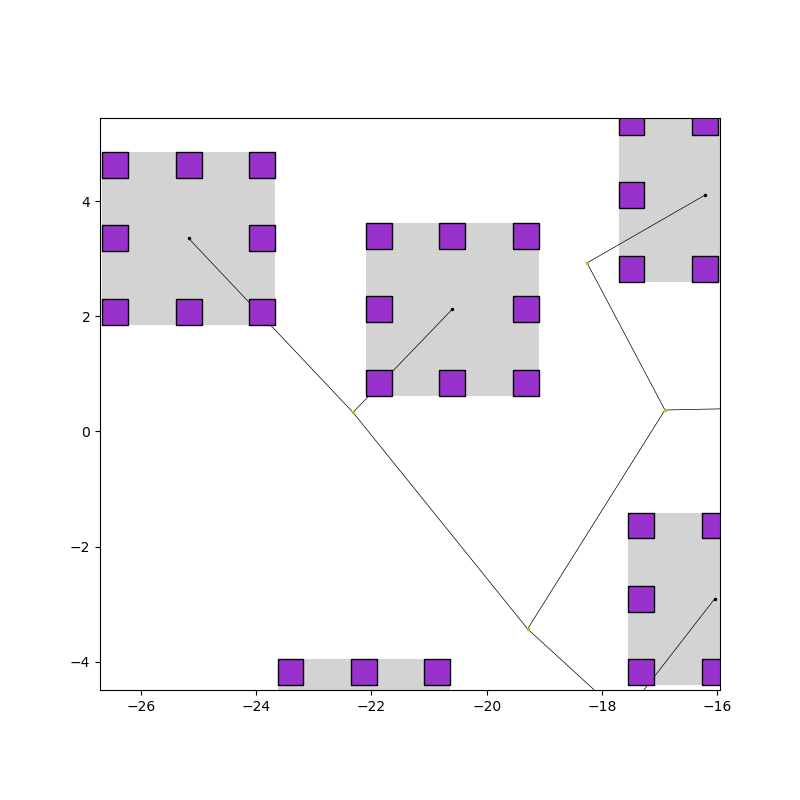

(32885,
 'a/layout616Revised.csv',
 [40063,
  38101,
  37862,
  39979,
  37478,
  37875,
  34969,
  39029,
  36982,
  37374,
  34783,
  36949,
  39784,
  38287,
  32885,
  37099,
  33014,
  36217,
  35316,
  37971,
  34192,
  34192,
  39144])

In [386]:
findlayout('rotationanimation/rot17.csv')
#thomaspunten = findlayout('rotationanimation/rot10.csv')[0]
#thomaslayout = findlayout('rotationanimation/rot10.csv')[1]

In [34]:
def fixherrings(points,layout):
    intersect = herringIntersections(points, layout)
    x, y = 0, 0
    tot = 0
    cur = -1
    for i in intersect:
        if i > tot:
            tot = i
    
    for l in layout:
        if l[0] == 'D':
            for t in layout:
                if t[0] == 'T':
                    if layout[t][1] == l:
                        intersect = herringIntersections(points, layout)
                        for itrsct in intersect:
                            if itrsct in intersect:
                                if layout[t][1] == intersect[itrsct][3] and layout[t][0] == intersect[itrsct][4]:
                                    x_list, y_list = [], []
                                    k=0.075
                                    i=0
                                    if layout[t][0][0] == 'D' and layout[t][1][0] == 'D':
                                        f =((layout[intersect[itrsct][3]][0] - layout[intersect[itrsct][4]][0]), (layout[intersect[itrsct][3]][1] - layout[intersect[itrsct][4]][1]))
                                    elif layout[t][0][0] == 'D' and layout[t][1][0] != 'D':
                                        f =((points[intersect[itrsct][3]][0] - layout[intersect[itrsct][4]][0]), (points[intersect[itrsct][3]][1] - layout[intersect[itrsct][4]][1]))
                                    elif layout[t][0][0] != 'D' and layout[t][1][0] == 'D':
                                        f =((layout[intersect[itrsct][3]][0] - points[intersect[itrsct][4]][0]), (layout[intersect[itrsct][3]][1] - points[intersect[itrsct][4]][1]))
                                    while k <= 0.825:
                                        x_list.append(layout[intersect[itrsct][3]][0] + f[0]*(0-k))
                                        y_list.append(layout[intersect[itrsct][3]][1] + f[1]*(0-k))
                                        x_list.append(layout[intersect[itrsct][3]][0] + f[0]*(0+k))
                                        y_list.append(layout[intersect[itrsct][3]][1] + f[1]*(0+k))
                                        k+=0.075
                                    unsolved, stillhere = True, True
                                    many = 0
                                    while unsolved:
                                        if many > 10:
                                            unsolved = False
                                            cur +=1
                                            logging.warning("Giving up on connection [" + str(cur) + '/' + str(tot) + ']')
                                            #drawfield(points,layout)
                                            break
                                        if i <= 21:
                                            templayout = layout
                                            x, y = x_list[i], y_list[i]
                                            i+=1
                                            templayout[l] = (x, y)
                                            checkinct = herringIntersections(points, templayout)
                                            if checkinct != {}:
                                                stillhere = False
                                                for c in checkinct:
                                                    if checkinct[c][3] == l:
                                                        stillhere = True
                                                if stillhere ==  False:
                                                    layout = templayout
                                                    unsolved = False
                                                    intersect = checkinct
                                                    cur +=1
                                                    logging.info("Fixed connection  [" + str(cur) + '/' + str(tot) + ']')
                                                    #drawfield(points,layout)
                                            else:
                                                layout = templayout
                                                unsolved = False
                                                intersect = checkinct
                                                cur +=1
                                                logging.info("Fixed connection [" + str(cur) + '/' + str(tot) + ']')
                                                #drawfield(points,layout)
                                        else:
                                            p=0
                                            for x in x_list:
                                                x_list[p] = x_list[p]+0.075
                                                y_list[p] = y_list[p]+0.075
                                                p+=1
                                            i = 0
                                            many += 1

In [222]:
line1=np.array(thomaslayout['D88'][:2])-np.array(thomaslayout['D23'][:2]) 
line2=np.array(thomaslayout['D23'][:2])-np.array(thomaslayout['D90'][:2])
costheta=line1.dot(line2)/(np.linalg.norm(line1)*np.linalg.norm(line2))
np.rad2deg(np.arccos(costheta))

KeyError: 'D88'

In [510]:
line1

array([-2.51636374,  3.03981015])

In [506]:
line1[0]/line1[1]

-0.827802927776337

In [508]:
line2[0]/line2[1]

-0.6818174893038209

In [517]:
line2=[(2*-0.827802927776337), 2]

In [522]:
line2

array([-4.98017475,  7.30426373])

In [35]:
def herrings(pt):
    """
    Give 8 herring locations for inserted antenna location
    
    Args:
        pt: id of the requested point
        
    Returns:
        array of the herring locations
   """
    herrings = []
    oneherring = np.array([[-0.225,0.225],[0.225,0.225],[0.225,-0.225],[-0.225,-0.225]])
    for xoffset in [-1.5+0.225, 0, 1.5-0.225]:
        for yoffset in [-1.5+0.225, 0, 1.5-0.225]:
            if xoffset == 0 and yoffset == 0:
                continue
            offset = np.array([xoffset, yoffset])
            herrings += [Polygon(np.array(pt) + offset + oneherring)]
    return herrings
def herringIntersections(points, layout):
    """
    finds all points where lines intersect with herrings
    
    Args:
        points_csv(str): file location with .csv of points
        lines_csv(str): file location with .csv of lines
    """
    pts = points
    lay = layout
    intersections = {}
    intersection_id=0
    for l in lay:
        if l[0] == 'T':
            if lay[l][0][0] == 'D':
                startp = lay[lay[l][0]]
            else:
                startp = pts[lay[l][0]]
                
            if lay[l][1][0] == 'D':
                endp = lay[lay[l][1]]
            else:
                endp = pts[lay[l][1]]
            
            line = LineString((startp, endp))
            for point in pts:
                if point[0] == 'M':
                    for her in herrings(pts[point]):
                        if line.intersection(her).length >= 0.025:
                            for mok in lay:
                                if lay[mok][1] == lay[l][0]:
                                    intersections[intersection_id] = point, pts[point], line.intersection(her).length, lay[l][0],lay[mok][0]
                                    intersection_id  += 1
    return intersections
def margin(pt):
    """
    Give margin location for inserted antenna location
    
    Args:
        pt: id of the requested point
        
    Returns:
        array of the margin's xy
    """
    margin = []
    one_margin = np.array([[-1.5,1.5],[1.5,1.5],[1.5,-1.5],[-1.5,-1.5]])
    margin += [Polygon(np.array(pt) + one_margin)]
    return margin
def marginIntersections(points, layout):
    """
    finds all points where lines intersect with the safety margin
    
    Args:
        points_csv(str): file location with .csv of points
        lines_csv(str): file location with .csv of lines
    """
    pts = points
    lay = layout
    intr = {}
    passedpoints = []
    int_id=0
    for l in lay:
        if l[0] == 'T':
            if lay[l][0][0] == 'D':
                startp = lay[lay[l][0]]
            else:
                startp = pts[lay[l][0]]
                
            if lay[l][1][0] == 'D':
                endp = lay[lay[l][1]]
            else:
                endp = pts[lay[l][1]]
            
            line = LineString((startp, endp))
            lineid = lay[l][1]
            for point in pts:
                if point[0] == 'M':
                    for mar in margin(pts[point]):
                        if line.intersection(mar).length != 0.0:
                            if point in passedpoints:
                                if lay[l][0][0] == 'D':
                                    intr[int_id] = point, pts[point], line.intersection(mar).length, lay[l][0], lay[l][1]
                                    int_id  += 1
                            else:
                                passedpoints.append(point)
    return intr

Documentation notes
- points 'Q1', 'M0' - 'M6', 'M46', 'M47' are positioned differently
    - 'Q1' is the cablehouse, origin of all cables
    - 'M46' and 'M47' locations are based on the location of 'Q1'
    - 'M0' is point 0, 0. and 'M1'- 'M6' locations are always the same
- Datastructures are as follows:
    - Points csv as ("cs/"rs)(0-9)(0-9)(0-9).csv"
        - starts with 'Q1' which is the location of the cablehouse
        - 'Q1' is followed by 'M0' to 'M95' which are all antennas
        - The file is closed with 'R1', 'R1' should be the deg rotation (like 272) and then a 0, so it doesn't crash (R1,272,0)
    - Layouts csv as "Layout(0-9)(0-9)(0-9).csv"
        - order doesn't matter
        - contains 'D0' - 'D(?)' which are cornerpoints for the lines
        - contains 'T0' - 'T(?)' which are lines written like: 'T0, D0, M77', 'T1, D12, D13'
        - contains 'R1', 'R1' should be the deg rotation (like 272) and then a 0, so it doesn't crash (R1,272,0)

In [373]:
thosmasp = {
 'M28': (3.0490000000000066, 8.685000000000002),
 'M29': (11.081000000000003, 9.113),
 'M30': (13.459000000000003, 6.126000000000005),
 'M31': (13.832000000000008, 3.024000000000001),
 'M15': (3.7280000000000086, 4.442999999999998),
 'M16': (6.597000000000008, 6.5930000000000035),
 'M17': (9.079999999999998, 3.9069999999999965),
 'M18': (10.278000000000006, -0.9869999999999948)}
thosmasl = {
 'D44': (4.760000000000005, 6.659999999999997),
 'D37': (4.760000000000005, 11.260000000000005),
 'D76': (5.307251109999996, 9.267331550000009),
 'D38': (8.560000000000002, 9.260000000000005),
 'D39': (9.060000000000002, 6.560000000000002),
 'D40': (11.260000000000005, 6.060000000000002),
 'D41': (11.260000000000005, 1.5600000000000023),
 'D42': (8.260000000000005, 1.5600000000000023), 
 'T0':('D39', 'D40'), 'T1':('D40', 'D41'), 'T2':('D41', 'D42'),
 'T3':('D76', 'D44'), 'T4':('D37', 'D76'), 'T5':('D76', 'D38'),
 'T6':('D38', 'D39'), 'T7':('D76', 'M28'), 'T8':('D44', 'M15'),
 'T9':('D44', 'M16'), 'T10':('D38', 'M29'), 'T11':('D40', 'M30'),
 'T12':('D39', 'M17'), 'T13':('D41', 'M31')}

In [767]:
thosmasp = {
    'M61': (20.701000000000008, 14.686999999999998),
    'M74': (22.430999999999997, 21.821000000000005),
    'M75': (28.276000000000003, 16.349000000000004),
    'M89': (35.094, 19.21900000000001)}
thosmasl = {
    'D0':(17,18),
    'D52': (32.260000000000005, 19.060000000000002),
    'D79': (20.793638209999997, 18.387092840000008),
    'D80': (26.127838210000007, 18.90330575),
    'T0':('D79', 'D80'),'T1':('D80', 'D52'), 'T2':('D80', 'M75'),
    'T3':('D52', 'M89'),'T4':('D79', 'M74'), 'T5':('D79', 'M61'),
    'T6':('D0', 'D79')}

In [784]:
thosmasp = {
    'M4':(13.566,-15.953),
    'M74':(8.052,-14.593)}
thosmasl = {
    'D91':(11.7081487623,-13.82275057589),
    'D110':(13.4276,-11.5523),
    'T0':('D110', 'D91'),'T1':('D91', 'M4'), 'T3':('D91', 'M74')}

<IPython.core.display.Javascript object>


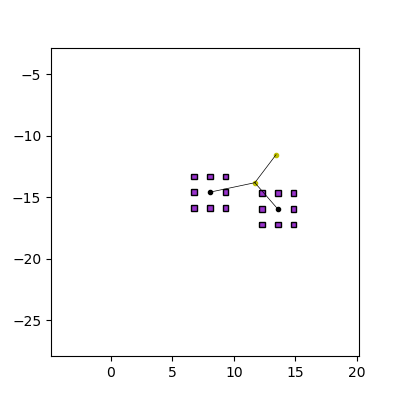

In [785]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-5, 20)
ax.set_ylim(-5, 20)
ax.set_aspect(1)

for m in thosmasp:
    for polygon in herrings(thosmasp[m]):
        ax.add_patch(descartes.PolygonPatch(polygon,  fc='darkorchid'))
    ax.plot(thosmasp[m][0], thosmasp[m][1], 'k.')
for d in thosmasl:
    if d[0]=='D':
        ax.plot(thosmasl[d][0], thosmasl[d][1], 'y.')
    else:
        if thosmasl[d][0][0] == 'D':
            fst = thosmasl[thosmasl[d][0]]
        elif thosmasl[d][0][0] == 'M':
            fst = thosmasp[thosmasl[d][0]]
        if thosmasl[d][1][0] == 'D':
            scd = thosmasl[thosmasl[d][1]]
        elif thosmasl[d][1][0] == 'M':
            scd = thosmasp[thosmasl[d][1]]
        ax.plot((fst[0], scd[0]), (fst[1], scd[1]), color='black', linewidth=0.5)

In [304]:
a=3
b=5
logging.warning(f"Giving up on connection from {a} to {b}")

In [52]:
def cleanup(layout):
    """
    Removes useless points from a layout
    
    Args:
        layout: dict of points and lines
    Returns:
        the same layout with altered values
    """
    
    firstenc = {}
    secondenc = {}
    poplist = {}
    for d in layout:
        count = 0
        if d[0] == 'D':
            for l in layout:
                if l[0] == 'T':
                    if (layout[l][1] == d or layout[l][0] == d):
                        count+=1
                        if layout[l][1] == d:
                            firstenc = layout[l]
                        elif layout[l][0] == d:
                            secondenc =  layout[l]
            if count == 2 and secondenc[1][0] == 'D' and firstenc[0][0] != 'Q':
                line1=np.array(layout[firstenc[0]])-np.array(layout[firstenc[1]]) 
                line2=np.array(layout[secondenc[0]])-np.array(layout[secondenc[1]])
                costheta=line1.dot(line2)/(np.linalg.norm(line1)*np.linalg.norm(line2))
                if np.rad2deg(np.arccos(costheta)) < 5:
                    poplist[d] = d
                    for l in layout:
                        if l[0] == 'T':
                            if layout[l] == firstenc:
                                layout[l] = (firstenc[0], secondenc[1])
                            if layout[l] == secondenc:
                                poplist[l] = l
    for pop in poplist:
        layout.pop(pop)
    return layout

In [391]:
lept = layoutmatrix(points,layout,0)[0]
for l in lept:
    if lept[l] > 105:
        print(l, lept[l])

In [399]:
def toPointsCSV(points, ptsfile):
    """
    Writes a set of points to a .csv file like:
    ptsfile:
            'LBD12',19,20
            'LBD13',13,14
    Args:
        points(dict): dict of points {id: (x, y)}
        ptsfile(str): filename to write points csv to

    """
    pfile = open(ptsfile,'w')
    for point in points:
        pfile.write(str(point) + ',')
        pfile.write(str(points[point][0]) + ',')
        pfile.write(str(points[point][1]) + '\n')
    pfile.close()

In [434]:
def go(rot, loc, name):
    """
    Finds a layout for the field that has a rotation "rot" and startpoint "loc"
    
    Args:
        rot(int): rotation in degrees
        loc(list): x and y coordinates of the startpoint like : (10,10)
        name(str): desired name of the field
    
    Rtrns:
         plot of points with best layout, name of best layout, and cost for reference.
    """
    field = centerfield('Backup Buitenlandse stations/de604.csv', rot)
    field['Q1'] = loc
    field['R0'] = (rot, 0)
    
    toPointsCSV(field, name)
    
    findlayout(name)

In [44]:
i = {'M0': (2, 2)}
l = {'D0': (0, 0), 'D1': (1, 0), 'D2': (2, 0), 'T1': ('D0', 'D1'), 'T2': ('D1', 'D2'), 'T3': ('D2', 'M0')}

<IPython.core.display.Javascript object>


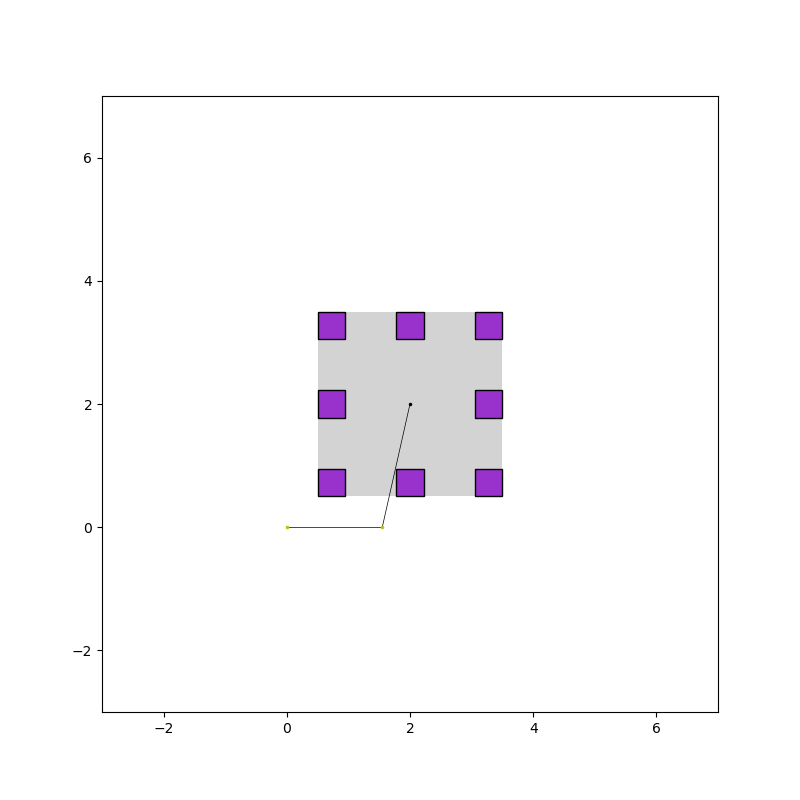

In [54]:
drawfield(i, l)

In [48]:
fixherrings(i, l)

In [53]:
cleanup(l)

{'D0': (0, 0), 'D2': (1.55, 0.0), 'T1': ('D0', 'D2'), 'T3': ('D2', 'M0')}